In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from scipy.optimize import curve_fit

In [2]:
plt.rcParams.update({
    'figure.autolayout': True,
    'savefig.bbox': 'tight',
    'svg.fonttype': 'none',
    'font.sans-serif': 'Arial',
    'font.size': 12,
    'boxplot.medianprops.linewidth': 2,
    'boxplot.flierprops.markeredgecolor': 'none',
    'boxplot.flierprops.markersize': 5})

# Running time and memory of TMarSel

Load wall time and memory usage

In [3]:
def convert_to_seconds(time):
    return sum(x * float(t) for x, t in zip([1, 60, 3600], time.split(':')[::-1]))

In [4]:
def parse_stats(file):
    wall_time = {}
    memory = {}
    with open(file, 'r') as f:
        for line in f:
            l = line.strip()
            if l.startswith('Command being timed'):
                matches = re.findall(r'--(S|G|k|rep) (\d+)', l)
                result = {key: int(value) for key, value in matches}
                key = f"rep_{result['rep']}_S_{result['S']}_G_{result['G']}_k_{result['k']}"
            if l.startswith('Elapsed (wall clock)'):
                time = l.split('(h:mm:ss or m:ss):')[-1].strip()
                time_seconds = convert_to_seconds(time)
                # Add to dict
                wall_time[key] = time_seconds
            if l.startswith('Maximum resident'):
                mem = int(l.split('(kbytes):')[-1].strip())
                # Add to dict
                memory[key] = mem
    return wall_time, memory

In [5]:
file = f'./bench.err'
wall_time, memory = parse_stats(file)

In [6]:
s_vals, g_vals, k_vals, r_times = [], [], [], []
for key, time in wall_time.items():
    rep = int(re.search(r'rep_(\d+)', key).group(1))
    s = int(re.search(r'S_(\d+)', key).group(1))
    g = int(re.search(r'G_(\d+)', key).group(1))
    k = int(re.search(r'k_(\d+)', key).group(1))
    if rep == 1:
        s_vals.append(s)
        g_vals.append(g)
        k_vals.append(k)
        r_times.append(time)

# Convert to numpy arrays
s_vals = np.array(s_vals)
g_vals = np.array(g_vals)
k_vals = np.array(k_vals)
r_times = np.array(r_times)


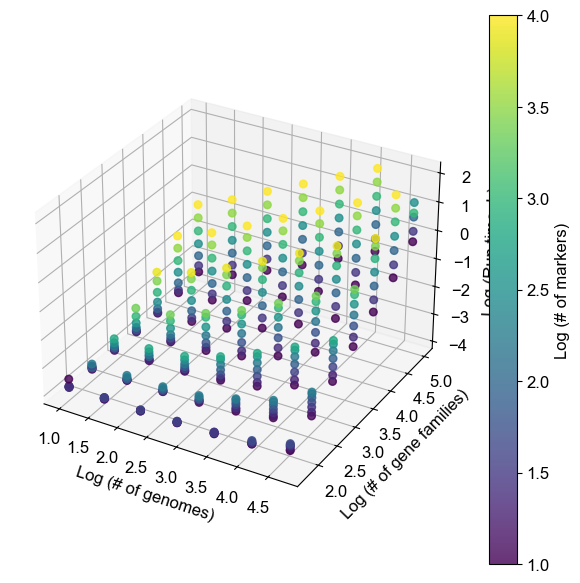

In [7]:
fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(projection = '3d')
# sc = ax.scatter(np.log10(s_vals), np.log10(g_vals), np.log10(k_vals), c = np.log10(r_times / 3600), cmap = 'viridis', s = 30, alpha = 0.6)
sc = ax.scatter(np.log10(s_vals), np.log10(g_vals), np.log10(r_times / 3600), 
                c = np.log10(k_vals), cmap = 'viridis', s = 30, alpha = 0.8)
# Use a logarithmic scale for the axes
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.set_zscale('log')

# Labels and Title
ax.set_xlabel('Log (# of genomes)')
ax.set_ylabel('Log (# of gene families)')
# ax.set_zlabel('Log (# of markers)')
ax.set_zlabel('Log (Run time, h)')
# ax.set_title('Run Time as a Function of Ss, Gs, and ks')

# Add a color bar
cbar = plt.colorbar(sc)
# cbar.set_label('Log (Runt time, h)')
cbar.set_label('Log (# of markers)')
plt.savefig(f'./figures/wall_time.svg')
plt.show()

In [8]:
s_vals, g_vals, k_vals, mems = [], [], [], []
for key, time in memory.items():
    rep = int(re.search(r'rep_(\d+)', key).group(1))
    s = int(re.search(r'S_(\d+)', key).group(1))
    g = int(re.search(r'G_(\d+)', key).group(1))
    k = int(re.search(r'k_(\d+)', key).group(1))
    if rep == 0:
        s_vals.append(s)
        g_vals.append(g)
        k_vals.append(k)
        mems.append(time)

# Convert to numpy arrays
s_vals = np.array(s_vals)
g_vals = np.array(g_vals)
k_vals = np.array(k_vals)
mems = np.array(mems)


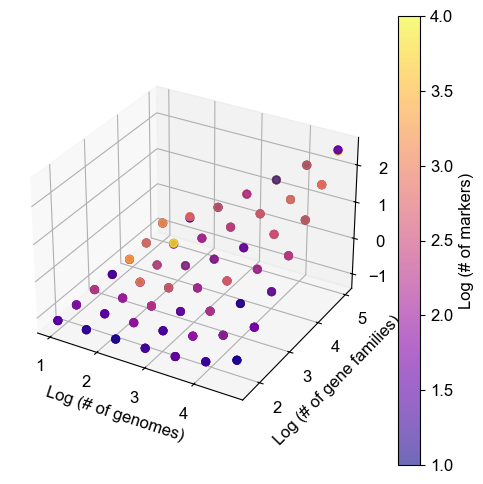

In [9]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(projection = '3d')
sc = ax.scatter(np.log10(s_vals), np.log10(g_vals), np.log10(mems * 1e-6), c = np.log10(k_vals), 
            cmap = 'plasma', s = 30, alpha = 0.6)

# Labels and Title
ax.set_xlabel('Log (# of genomes)')
ax.set_ylabel('Log (# of gene families)')
# ax.set_zlabel('Log (# of markers)')
ax.set_zlabel('Log (Memory, GB)')
# ax.set_title('Run Time as a Function of Ss, Gs, and ks')

# Add a color bar
cbar = plt.colorbar(sc)
# cbar.set_label('Log (Memory, GB)')
cbar.set_label('Log (# of markers)')
plt.savefig(f'./figures/memory.svg')
plt.show()

Fixing S and G

In [10]:
Ss = np.logspace(1, 4.7, num = 7, dtype = int)
Gs = np.logspace(1.7, 5, num = 7, dtype = int)
rep = 0
print(f'Ss: {Ss}')
print(f'Gs: {Gs}')

Ss: [   10    41   171   707  2928 12115 50118]
Gs: [    50    177    630   2238   7943  28183 100000]


In [11]:
s_vals, g_vals, k_vals, r_times = [], [], [], []
for key, time in wall_time.items():
    rep = int(re.search(r'rep_(\d+)', key).group(1))
    s = int(re.search(r'S_(\d+)', key).group(1))
    g = int(re.search(r'G_(\d+)', key).group(1))
    k = int(re.search(r'k_(\d+)', key).group(1))
    if rep == 0 and s == 12115:
        s_vals.append(s)
        g_vals.append(g)
        k_vals.append(k)
        r_times.append(time)

# Convert to numpy arrays
s_vals = np.array(s_vals)
g_vals = np.array(g_vals)
k_vals = np.array(k_vals)
r_times = np.array(r_times)


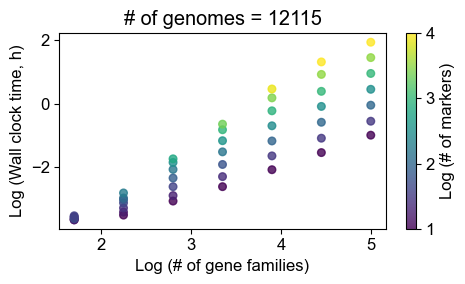

In [12]:
fig = plt.figure(figsize = (5, 3))
# sc = plt.scatter(np.log10(g_vals), np.log10(k_vals),
#          c = np.log10(r_times / 3600), cmap = 'viridis', s = 30, alpha = 0.8)
sc = plt.scatter(np.log10(g_vals), np.log10(r_times / 3600), c = np.log10(k_vals),
        cmap = 'viridis', s = 30, alpha = 0.8)

# Labels and Title
plt.xlabel('Log (# of gene families)')
# plt.ylabel('Log (# of markers)')
plt.ylabel('Log (Wall clock time, h)')
plt.title('# of genomes = 12115')

# Add a color bar
cbar = plt.colorbar(sc)
# cbar.set_label('Log (Runt time, h)')
cbar.set_label('Log (# of markers)')
plt.show()

In [13]:
s_vals, g_vals, k_vals, r_times = [], [], [], []
for key, time in wall_time.items():
    rep = int(re.search(r'rep_(\d+)', key).group(1))
    s = int(re.search(r'S_(\d+)', key).group(1))
    g = int(re.search(r'G_(\d+)', key).group(1))
    k = int(re.search(r'k_(\d+)', key).group(1))
    if rep == 0 and g == 28183:
        s_vals.append(s)
        g_vals.append(g)
        k_vals.append(k)
        r_times.append(time)

# Convert to numpy arrays
s_vals = np.array(s_vals)
g_vals = np.array(g_vals)
k_vals = np.array(k_vals)
r_times = np.array(r_times)


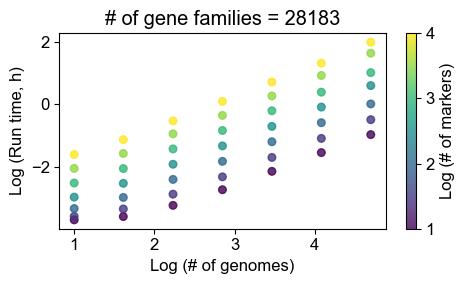

In [14]:
fig = plt.figure(figsize = (5, 3))
# sc = plt.scatter(np.log10(s_vals), np.log10(k_vals), c = np.log10(r_times / 3600), 
#             cmap = 'viridis', s = 30, alpha = 0.8)
sc = plt.scatter(np.log10(s_vals), np.log10(r_times / 3600), c = np.log10(k_vals), 
            cmap = 'viridis', s = 30, alpha = 0.8)


# Labels and Title
plt.xlabel('Log (# of genomes)')
# plt.ylabel('Log (# of markers)')
plt.ylabel('Log (Run time, h)')
plt.title('# of gene families = 28183')

# Add a color bar
cbar = plt.colorbar(sc)
# cbar.set_label('Log (Runt time, h)')
cbar.set_label('Log (# of markers)')
plt.show()

Let us do a better plot...

In [15]:
rep = 0

In [16]:
data = {}
for G in Gs:
    for S in Ss:
        # Number of markers to select
        if G <= 10000:
            ks = np.logspace(1, round(np.log10(G), 2), num = 7, dtype = int)
            # For the last value, substract one
            ks[-1] = ks[-1] - 1
        else:
            ks = np.logspace(1, 4, num = 7, dtype = int) # up to 10,000
        times = np.empty(len(ks))
        mems = np.empty(len(ks))
        for i, k in enumerate(ks):
            key = f'rep_{rep}_S_{S}_G_{G}_k_{k}'
            times[i] = wall_time[key]
            mems[i] = memory[key]
        data[f'G_{G}_S_{S}'] = [ks, times, mems]

In [17]:
print(f'G: {Gs}')
print(f'S: {Ss}')

G: [    50    177    630   2238   7943  28183 100000]
S: [   10    41   171   707  2928 12115 50118]


In [18]:
colors_time = ['#00ffd0', '#00e9d8', '#00d3e0', '#00bde8', '#00a7ef', '#0091f7', '#007bff']
colors_memory = ['#fcf3c4', '#fcdbbe', '#fbc3b8', '#fbabb2', '#fa92ac', '#fa7aa6', '#f962a0']
# colors = colors[::-1]

In [19]:
def power_law(x, a, b):
    return a * x**b

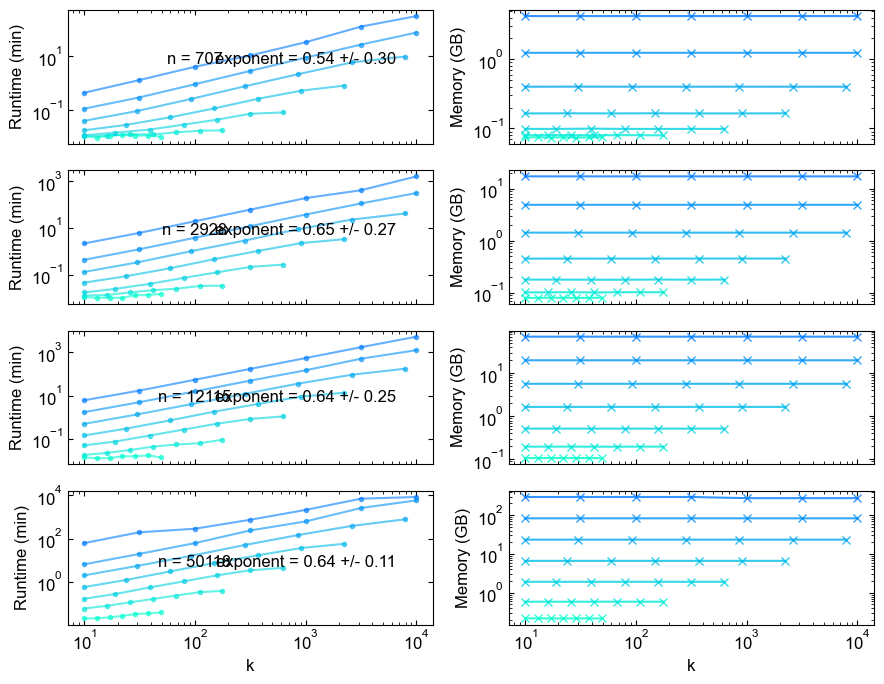

In [22]:
# Multiple subplots
fig, axs = plt.subplots(4, 2, figsize = (9, 7), sharex = True, sharey = False)
for i, S in enumerate(Ss[3:]):
        exponents = np.empty(len(Gs))
        for j, G in enumerate(Gs):
                ks, times, mems = data[f'G_{G}_S_{S}']
                # Fit the power-law function
                params, _ = curve_fit(power_law, ks, times)
                _, exponent = params
                exponents[j] = exponent
                # Time
                axs[i, 0].plot(ks, times / 60, label = f'm = {G}', marker = '.', 
                        alpha = 0.6, color = colors_time[j])
                axs[i, 0].set_xscale('log')
                axs[i, 0].set_yscale('log')
                # axs[i, 0].legend()
                axs[i, 0].tick_params(top=True, right=True, direction='in', which='both')
                # Test exponent
                # axs[i, 0].plot(ks, power_law(ks, *params) / 60, color = 'r')
                # Memory
                axs[i, 1].plot(ks, mems * 1e-6, label = f'm = {G}', marker = 'x', 
                        alpha = 0.8, color = colors_time[j])
                axs[i, 1].set_xscale('log')
                axs[i, 1].set_yscale('log')
                # axs[i, 1].legend()
                axs[i, 1].tick_params(top=True, right=True, direction='in', which='both')

                # For col 0, label is 'Wall clock time (h)'
                axs[i, 0].set_ylabel('Runtime (min)')
                axs[i, 1].set_ylabel('Memory (GB)')
        axs[i, 0].text(100, 5, f'n = {S}', ha = 'center', fontsize = 12, color = 'k')
        axs[i, 0].text(1000, 5, f'exponent = {exponents.mean():.2f} +/- {exponents.std():.2f}',
         ha = 'center', fontsize = 12, color = 'k')
        # axs[i, 1].text(10, 5, f'n = {S}', ha = 'center', fontsize = 12, color = 'k')

axs[3, 0].set_xlabel('k')
axs[3, 1].set_xlabel('k') 
plt.savefig(f'./figures/run_time_memory.svg')

Exponent

In [21]:
for i, S in enumerate(Ss[3:]):
    exponents = np.empty(len(Gs))
    for j, G in enumerate(Gs):
        ks, times, mems = data[f'G_{G}_S_{S}']
        # Fit the power-law function
        params, _ = curve_fit(power_law, ks, times)
        _, exponent = params
        exponents[j] = exponent
        print(f'\tFor S = {S}, G = {G}, exponent = {exponent:.2f}')
    print(f'Mean exponent {exponents.mean():.2f}, std = {exponents.std():.2f}')


	For S = 707, G = 50, exponent = 0.03
	For S = 707, G = 177, exponent = 0.19
	For S = 707, G = 630, exponent = 0.49
	For S = 707, G = 2238, exponent = 0.64
	For S = 707, G = 7943, exponent = 0.63
	For S = 707, G = 28183, exponent = 0.91
	For S = 707, G = 100000, exponent = 0.86
Mean exponent 0.54, std = 0.30
	For S = 2928, G = 50, exponent = 0.25
	For S = 2928, G = 177, exponent = 0.37
	For S = 2928, G = 630, exponent = 0.62
	For S = 2928, G = 2238, exponent = 0.65
	For S = 2928, G = 7943, exponent = 0.67
	For S = 2928, G = 28183, exponent = 0.91
	For S = 2928, G = 100000, exponent = 1.10
Mean exponent 0.65, std = 0.27
	For S = 12115, G = 50, exponent = 0.11
	For S = 12115, G = 177, exponent = 0.55
	For S = 12115, G = 630, exponent = 0.64
	For S = 12115, G = 2238, exponent = 0.66
	For S = 12115, G = 7943, exponent = 0.69
	For S = 12115, G = 28183, exponent = 0.85
	For S = 12115, G = 100000, exponent = 0.98
Mean exponent 0.64, std = 0.25
	For S = 50118, G = 50, exponent = 0.45
	For S = 